In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt #Plot Bibliothek
import seaborn as sns #importing Seaborn's for plots
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler 
from timeit import default_timer as timer

import math
import bokeh   # graphische, interaktive Plots
from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
from bokeh.models import HoverTool, LassoSelectTool, Plot, WheelZoomTool, BoxZoomTool, ResetTool
output_notebook(resources=None, verbose=True, hide_banner=True)


# logging einrichten. (Alle Standard handler werden ausgeschaltet)
scriptname='Ames Cluster.ipynb'
logtext="" # Variable zum additiven Wegschreiben
import logging
logging.getLogger().removeHandler(logging.getLogger())
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s;%(levelname)s;%(message)s;",
    datefmt="%Y-%m-%d %H:%M:%S",
    encoding='utf-8',
    handlers=[logging.FileHandler("AllScripts.log", "a")]
)



In [4]:
#Daten einlesen und vorbereiten 

#path = 'c:/myBox/Projekte/FHDW/Kurs DAML/Daten/AmesHousing.csv' # für lokale Dateien
path = 'https://github.com/WilliHahn/FHDW/raw/main/AmesHousing.csv'
df = pd.read_csv(path, sep=',') 

df.shape
df.drop(index=df.loc[df.loc[:,'Gr Liv Area'] > 4000].index, inplace=True)
df['TotalLivingSF'] = df['Gr Liv Area'] + df['Total Bsmt SF'] - df['Low Qual Fin SF']
df['TotalSqFeet'] = df['Total Bsmt SF'] + df['1st Flr SF'] + df['2nd Flr SF']
df['TotalBathroom'] = df['Full Bath']  + df['Bsmt Full Bath'] + 0.5 * (df['Half Bath'] + df['Bsmt Half Bath'] )
df['HouseAge'] = df['Yr Sold'] - df['Year Built']
df['RemodelAge'] = df['Yr Sold'] - df['Year Remod/Add']
df['IsreModeled'] = np.where(df['Year Remod/Add']  == df['Year Built'], 1, 0)
df['IsNew'] = np.where(df['Yr Sold'] == df['Year Built'], 1, 0)
df.loc[df['Year Remod/Add'] < df['Year Built'], 'Year Remod/Add'] = df['Year Built']
df.loc[df['Year Remod/Add'] > df['Yr Sold'], 'Year Remod/Add'] = df['Yr Sold']
df.drop('Year Remod/Add',axis=1,inplace=True)
df.drop('Mo Sold',axis=1,inplace=True)

#df.drop('Kitchen AbvGr',axis=1,inplace=True) # betriff 129 Häuser. Korreliert mit Buildung Type Duplex

df['Bsmt Qual'] = df['Bsmt Qual'].map({'Ex':4,'Gd':3,'TA':2.5,'Fa':2,'Po':1.5,'None':0})
df['Bsmt Cond'] = df['Bsmt Cond'].map({'Ex':4,'Gd':3,'TA':2.5,'Fa':2,'Po':1.5,'None':0})
df['BsmtFin Type 1'] = df['BsmtFin Type 1'].map({'GLQ':4,'ALQ':3.5,'BLQ':3,'Rec':2.5,'LwQ':2,'Unf':1.5,'None':0})
df['BsmtFin Type 2'] = df['BsmtFin Type 2'].map({'GLQ':4,'ALQ':3.5,'BLQ':3,'Rec':2.5,'LwQ':2,'Unf':1.5,'None':0})
df['Bsmt Exposure'] = df['Bsmt Exposure'].map({'Gd':3,'Av':2,'Mn':1,'No':0,'None':0})
df['Bsmt Qual'] = df['Bsmt Qual'].fillna(0)
df['BsmtFin Type 1'] = df['BsmtFin Type 1'].fillna(0)
df['BsmtFin Type 2'] = df['BsmtFin Type 2'].fillna(0)
df['Bsmt Exposure'] = df['Bsmt Exposure'].fillna(0)
df['Bsmt Cond'] = df['Bsmt Cond'].fillna(0)
df['BsmtFin SF 1'] = df['BsmtFin SF 1'].fillna(0)
# 2 Datensätzen mit fehlender Badangabe entfernen
for i in df[df['Bsmt Full Bath'].isnull()==True].loc[:,'Order']:
    df = df[df['Order']!=i]
print(df.shape)
df.drop('MS SubClass',axis=1,inplace=True)
df['Neighborhood_org'] = df['Neighborhood']
df = pd.get_dummies(df, columns=['Neighborhood'], drop_first=False)
df.drop('Neighborhood_Landmrk',axis=1,inplace=True) # weil nur 2 Datensätze
df.drop('Neighborhood_GrnHill',axis=1,inplace=True) # weil nur 1 Datensatz
neighborhood_means = df.groupby('Neighborhood_org')['Lot Frontage'].mean()
neighborhood_means = neighborhood_means.fillna(np.mean(neighborhood_means))
df['Lot Frontage'] = df['Lot Frontage'].fillna(df['Neighborhood_org'])
df['Lot Frontage'] = df['Lot Frontage'].map(lambda x: neighborhood_means[x] if type(x)==str else x)
df.drop('Lot Frontage',axis=1,inplace=True) # high correlation to lot area
df.drop('Neighborhood_org',axis=1,inplace=True)
df['Lot Shape'] = df['Lot Shape'].map({'Reg':0,'IR1':1,'IR2':2,'IR3':2})
df['Land Slope'] = df['Land Slope'].map({'Gtl':0,'Mod':1,'Sev':2})
df.drop('Land Contour',axis=1,inplace=True) # double to Land Slope

#df1 = df.loc[df["Lot Area"] <=100000 ] # 3 Häuser entfernen
#df=df1
df = pd.get_dummies(df, columns=['Lot Config'])

df['Railroad_Adjacent'] = df['Condition 1'].map(lambda x: 'RRAn' if x=='1' else 0) # 
df['Railroad_Adjacent'] = df['Condition 1'].map(lambda x: 'RRAe' if x=='1' else 0) # 
df['Railroad_Adjacent'] = df['Condition 2'].map(lambda x: 'RRAn' if x=='1' else 0) # 
df['Railroad_Adjacent'] = df['Condition 2'].map(lambda x: 'RRAe' if x=='1' else 0) # 
df['Railroad_Near'] = df['Condition 1'].map(lambda x: 'RRNn' if x=='1' else 0) # 
df['Railroad_Near'] = df['Condition 1'].map(lambda x: 'RRNe' if x=='1' else 0) # 
df['Railroad_Near'] = df['Condition 2'].map(lambda x: 'RRNn' if x=='1' else 0) # 
df['Railroad_Near'] = df['Condition 2'].map(lambda x: 'RRNe' if x=='1' else 0) # 
df['Street_Feeder'] = df['Condition 1'].map(lambda x: 'Feedr' if x=='1' else 0) # 
df['Street_Feeder'] = df['Condition 2'].map(lambda x: 'Feedr' if x=='1' else 0) # 
df['Street_Aterial'] = df['Condition 1'].map(lambda x: 'Artery' if x=='1' else 0) # 
df['PosFeature_Aterial'] = df['Condition 2'].map(lambda x: 'Artery' if x=='1' else 0) # 
df['PosFeature_Adjacent'] = df['Condition 1'].map(lambda x: 'PosA' if x=='1' else 0) # 
df['PosFeature_Adjacent'] = df['Condition 2'].map(lambda x: 'PosA' if x=='1' else 0) # 
df['PosFeature_Near'] = df['Condition 1'].map(lambda x: 'PosN' if x=='1' else 0) # 
df['PosFeature_Near'] = df['Condition 2'].map(lambda x: 'PosN' if x=='1' else 0) # 
df.drop('Condition 1',axis=1,inplace=True) # 
df.drop('Condition 2',axis=1,inplace=True) # 

df['Garage Yr Blt'] = df['Garage Yr Blt'].fillna(df['Year Built'])
df['GarageAge'] = df['Yr Sold'] - df['Garage Yr Blt']
df.drop('Yr Sold',axis=1,inplace=True)
#df.drop('Year Built',axis=1,inplace=True)
#df.drop('Garage Yr Blt',axis=1,inplace=True)
df['Garage Type'] = df['Garage Type'].fillna('None')
df['Garage Finish'] = df['Garage Finish'].fillna('None')
df['Garage Qual'] = df['Garage Qual'].fillna('None')
df['Garage Cond'] = df['Garage Cond'].fillna('None')
df['Garage Cars'] = df['Garage Cars'].fillna(0)
df = pd.get_dummies(df, columns=['Garage Type'], drop_first=False)
df['Garage Finish'] = df['Garage Finish'].map({'Fin':3,'RFn':2,'Unf':1,'None':0})
df['Garage Qual'] = df['Garage Qual'].map({'Ex':10,'Gd':7,'TA':5,'Fa':3,'Po':1,'None':0})
df['Garage Cond'] = df['Garage Cond'].map({'Ex':10,'Gd':7,'TA':5,'Fa':3,'Po':1,'None':0})
df['Garage Area'] = df['Garage Area'].fillna(0)

df['Fireplace Qu'] = df['Fireplace Qu'].fillna('None')
df['Fireplace Qu'] = df['Fireplace Qu'].map({'Ex':10,'Gd':7,'TA':5,'Fa':3,'Po':1,'None':0})
df.drop(columns=['Fireplaces'], inplace=True, axis=1)   # wgegn hoher Korrelation zu Fireplace Quality
df['Pool QC'] = df['Pool QC'].fillna('None')
df['Pool QC'] = df['Pool QC'].map({'Ex':7,'Gd':4,'TA':3,'Fa':2,'None':0})
df['Fence'] = df['Fence'].fillna('None')
df['Fence'] = df['Fence'].map({'GdPrv':3,'GdWo':2,'MnPrv':1,'MnWw':1,'None':0})

#df['Alley'] = df['Alley'].fillna(0)
#df['Alley Grvl'] = df['Alley'].map(lambda x: 1 if x=='Grvl' else 0) # 120 Häuser
df['Alley Pave'] = df['Alley'].map(lambda x: 1 if x=='Pave' else 0) # 78 Häoser
#df['Alley'] = df['Alley'].map(lambda x: 1 if x!=0 else 0)
df.drop(columns=['Alley'], inplace=True, axis=1)   # wegen hohen Korrelationen
df = pd.get_dummies(df, columns=['Misc Feature'], drop_first=False)
df['Mas Vnr Type'] = df['Mas Vnr Type'].fillna('None')
df = pd.get_dummies(df, columns=['Mas Vnr Type'], drop_first=False)
#df.drop('Mas Vnr Type_None',axis=1,inplace=True)
df['Mas Vnr Area'] = df['Mas Vnr Area'].fillna(0)


df['Utilities'] = df['Utilities'].map({'AllPub':0,'NoSewr':1,'NoSeWa':2,'ELO':3})
df.drop('Utilities',axis=1,inplace=True) # 99,9% equals AllPub
for i in ['Exter Qual','Exter Cond','Kitchen Qual']:
    df[i] = df[i].map({'Ex':4,'Gd':1,'TA':0,'Fa':-1,'Po':-4})
df['Heating QC'] = df['Heating QC'].map({'Ex':2,'Gd':1,'TA':0,'Fa':-2,'Po':-4})
df['Electrical'] = df['Electrical'].map({'SBrkr':0,'FuseA':1,'FuseF':2, 'FuseP':3, 'Mix':1.5})
df['Electrical'] = df['Electrical'].fillna(1.5)
df['Functional'] = df['Functional'].map({'Typ':0,'Min1':1,'Min2':2,'Mod':3,'Maj1':4,'Maj2':5,'Sev':6,'Sal':7})
df['Paved Drive'] = df['Paved Drive'].map({'N':0,'P':1,'Y':2})

df = pd.get_dummies(df, columns=['MS Zoning',
                                     'Street',
                                     'House Style',
                                     'Bldg Type',
                                     'Roof Style',
                                     'Roof Matl',
                                     'Exterior 1st',
                                     'Exterior 2nd', 
                                     'Foundation', 
                                     'Heating', 
                                     'Central Air',
                                     'Sale Condition',
                                     'Sale Type'], 
                      drop_first=False)
df.drop(columns=['PID'], inplace=True, axis=1)   # eindeutige Primärschlüssel entfernen

df2=df.copy()  #reorg data frame
print (df2.info(verbose=True))
#df2.describe()

(2923, 87)
<class 'pandas.core.frame.DataFrame'>
Index: 2923 entries, 0 to 2929
Data columns (total 213 columns):
 #    Column                  Dtype  
---   ------                  -----  
 0    Order                   int64  
 1    Lot Area                int64  
 2    Lot Shape               int64  
 3    Land Slope              int64  
 4    Overall Qual            int64  
 5    Overall Cond            int64  
 6    Year Built              int64  
 7    Mas Vnr Area            float64
 8    Exter Qual              int64  
 9    Exter Cond              int64  
 10   Bsmt Qual               float64
 11   Bsmt Cond               float64
 12   Bsmt Exposure           float64
 13   BsmtFin Type 1          float64
 14   BsmtFin SF 1            float64
 15   BsmtFin Type 2          float64
 16   BsmtFin SF 2            float64
 17   Bsmt Unf SF             float64
 18   Total Bsmt SF           float64
 19   Heating QC              int64  
 20   Electrical              float64
 21   1st Fl

C:\myPrograms\Anaconda3\envs\FHDW1-pip-311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


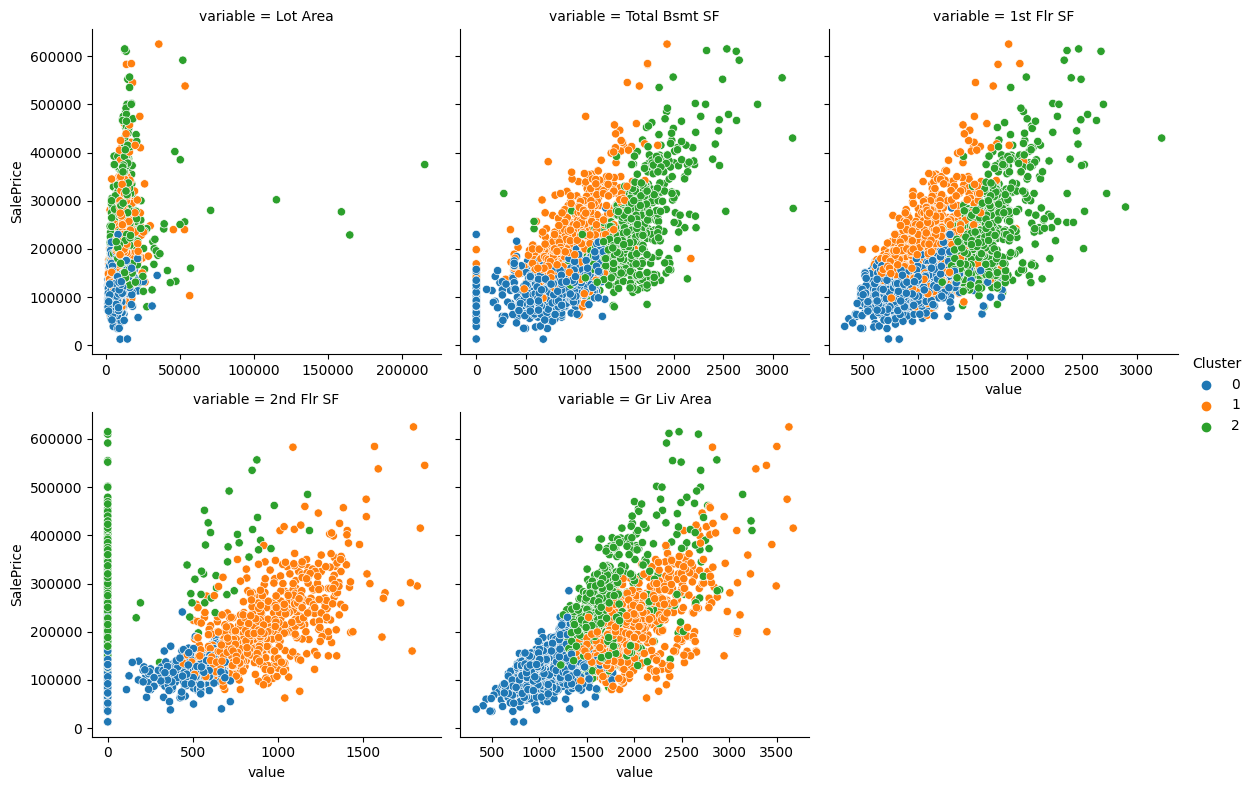

In [3]:
# Clusteranalyse 

X = df2.copy()
y = X.pop("SalePrice")

def my_cluster(X,y,n_clusters, features):
    # Standardize
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters = n_clusters, n_init=n_clusters,random_state=0)
    X["Cluster"] = kmeans.fit_predict(X_scaled)    
    # plot it
    Xy = X.copy()
    Xy["Cluster"] = Xy.Cluster.astype("category")
    Xy["SalePrice"] = y
    _= sns.relplot(
        x="value", y="SalePrice", hue="Cluster", col="variable",
        height=4, aspect=1, facet_kws={'sharex': False}, col_wrap=3,
        data=Xy.melt(value_vars=features, id_vars=["SalePrice", "Cluster"],),
    );


features = ['Lot Area', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF','Gr Liv Area']
n_clusters = 3
my_cluster (X, y, n_clusters, features)